## Aggregate the network for only Solar CF time series

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
sys.path.append('../src')

from utils import Config, DataProcessor, Network, find_matching_folder
from models import SpatialAggregation, TemporalAggregation
from visuals import Visualization

In [31]:
config = Config(demand = "k-interpolation", time_scale="weekly")
print(config)

Config(year=2013, demand='k-interpolation', k_neighbors_CF=3, k_weight_demand=3, time_scale='weekly', drop_duplicates=True, n_repr=5, k_representative_days=5, weights={'position': 1.0, 'time_series': 1.0, 'duration_curves': 1.0, 'rdc': 1.0, 'intra_correlation': 1.0, 'inter_correlation': 1.0, 'supply_demand_mismatch': 1.0}, file_paths={'nodes': '../DATA/dev/NewEngland-HVbuses.csv', 'demand': '../DATA/dev/demand_hist/county_demand_local_hourly_2013.csv', 'wind_cf': '../DATA/dev/CapacityFactors_ISONE/Wind/cf_Wind_0.22m_2013.nc', 'solar_cf': '../DATA/dev/CapacityFactors_ISONE/Solar/cf_Solar_0.22m_2013.nc', 'demand_lat_lon': '../DATA/Dev/new_england_counties2019.csv'})


In [32]:
nodes_df, demand_df, wind_df, solar_df, wind_CF, solar_CF = DataProcessor.import_and_interpolate_data(config)

Number of duplicates deleted in nodes_df: 2238


In [33]:
TimeSeries = {'solar': solar_df} #,'solar': solar_df};

In [34]:
network = Network(nodes_df, demand_df, TimeSeries, config)

The 'features' dictionary has been created and can be accessed as '.features'
It is a dictionary with keys for each node in range(0, 2605).
Each value is a dictionary with the features of that node.

Example structure:
network.features[0].keys() = dict_keys(['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'supply_demand_mismatch'])

Details:
  - Position: A tuple (latitude, longitude) of that node.
  - Time series: A dictionary with keys for each time series type in dict_keys(['solar'])
    and values as the time series itself.
  - Duration Curves: A dictionary with keys for each time series type in dict_keys(['solar'])
    and values as the duration curve of the time series.
  - Ramp Duration Curves (RDCs): A dictionary with keys for each time series type dict_keys(['solar'])
    and values as the RDC (found by differentiating and subsequently sorting) of the time series.
  - Correlation: A dictionary with keys as tuples of types of time series
    and values as 

In [35]:
aggregator = SpatialAggregation(network.features, config)

In [36]:
folder_name = find_matching_folder(config, list(TimeSeries.keys()), num_nodes1=len(network.features), num_nodes2=len(network.features))
load = {"yes": folder_name, "no": None}
aggregator.set_distance_metrics(dir_distance_metrics = load["yes"])

Searching for a folder with the following configuraton:
year: 2013, 
demand: k-interpolation, 
k_neighbors_CF: 3, 
k_weight_demand: 3, 
time_scale: weekly, 
drop_duplicates: True,
time series: ['solar']
...
Metadata file not found in '2025-03-24 22h20 - Distance Metrics'
Metadata file not found in '2025-03-24 22h23 - Distance Metrics'
Found matching folder: '2025-03-24 23h58 - Distance Metrics'


In [37]:
print(aggregator.distance_metrics.keys())

dict_keys(['duration_curves_distance', 'inter_correlation_distance', 'position_distance', 'rdc_distance', 'supply_demand_mismatch_distance', 'time_series_distance'])


In [38]:
# optimized_assignment_dict = aggregator.optimize()

In [47]:
config.weights = {
        'position': 1.0,
        'time_series': 1.0,
        'duration_curves': 1.0,
        'rdc': 1.0,
        'intra_correlation': 1.0,
        'inter_correlation': 1.0,
        'supply_demand_mismatch': 1.0
    }

cluster_assignment_dict = aggregator.cluster_KMedoids()

Clustering with 2605 nodes and 5 representatives.
The weights are: {'position': 1.0, 'time_series': 1.0, 'duration_curves': 1.0, 'rdc': 1.0, 'intra_correlation': 1.0, 'inter_correlation': 1.0, 'supply_demand_mismatch': 1.0}


In [48]:
pd.DataFrame(aggregator.distance_metrics["inter_correlation_distance"][:10,:10])

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.000000,0.000900,0.000609,0.000602,0.000000,0.001312,0.000548,0.000527,0.001316
1,1.0,0.000900,0.000000,0.000052,0.000028,0.000858,0.000057,0.000100,0.000125,0.000109
2,2.0,0.000609,0.000052,0.000000,0.000005,0.000575,0.000133,0.000007,0.000018,0.000146
3,3.0,0.000602,0.000028,0.000005,0.000000,0.000565,0.000132,0.000022,0.000033,0.000152
4,4.0,0.000000,0.000858,0.000575,0.000565,0.000001,0.001264,0.000507,0.000485,0.001242
5,5.0,0.001312,0.000057,0.000133,0.000132,0.001264,0.000001,0.000178,0.000219,0.000010
6,6.0,0.000548,0.000100,0.000007,0.000022,0.000507,0.000178,0.000000,0.000001,0.000171
7,7.0,0.000527,0.000125,0.000018,0.000033,0.000485,0.000219,0.000001,0.000000,0.000184
8,8.0,0.001316,0.000109,0.000146,0.000152,0.001242,0.000010,0.000171,0.000184,0.000000
9,9.0,0.000074,0.000472,0.000264,0.000266,0.000059,0.000765,0.000214,0.000196,0.000752


In [42]:
eval_KMedoids = aggregator.compute_eval_metrics(aggregation_method = 'kmedoids', type="custom")

In [43]:
# eval_opti = aggregator.compute_metrics(aggregation_method = 'optimization', type="custom")

In [44]:
visualizer = Visualization(aggregator)

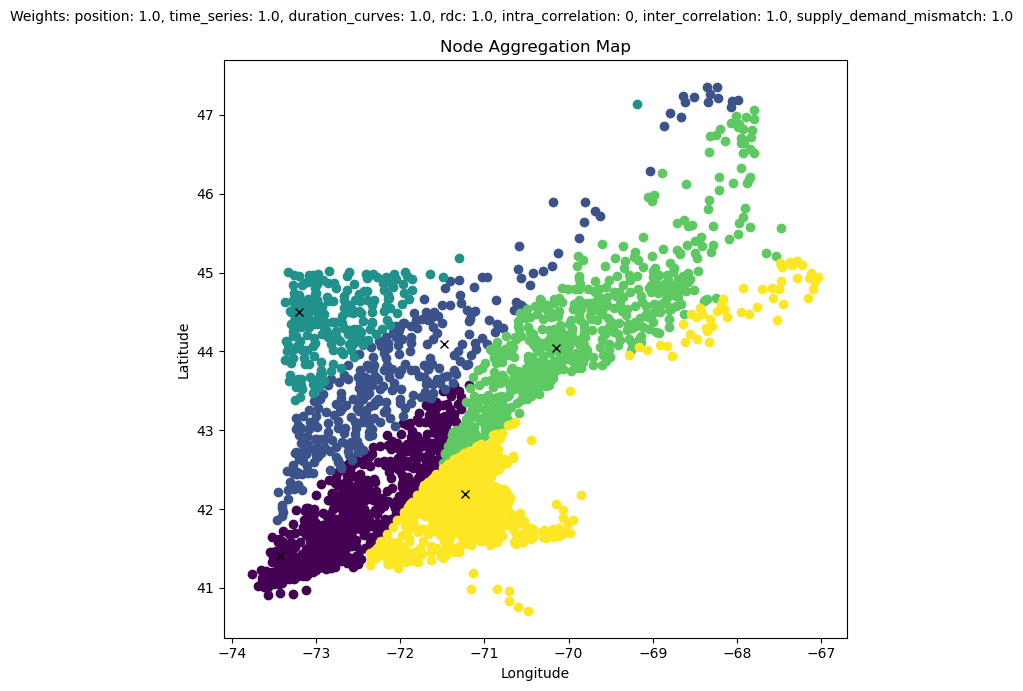

In [45]:
visualizer.plot_map(aggregation_method='kmedoids')

In [46]:
# visualizer.plot_map(aggregation_method='optimization')